In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3



 - import everything up top in one
 - add release years for tmdb; filter by 2000 or later
 - merge into tmdb 
 - justify budget outliers 
 - outliers for revenue, both domestic and world 
 - low vote counts?
 - check for v prolific directors/writers
 - calculate the ROI
 

In [2]:
# Import TN Movie Budgets data
tn_movie_budgets = pd.read_csv('../data/tn.movie_budgets.csv.gz')

#Import TMDB data
tmdb_movies = pd.read_csv('../data/tmdb.movies.csv.gz')

#rt_reviews = pd.read_csv('../data/rt.reviews.tsv.gz', sep = '\t', encoding='latin-1')
#rt_movie_info = pd.read_csv('../data/rt.movie_info.tsv.gz', sep = '\t')
#movie_gross = pd.read_csv('../data/bom.movie_gross.csv.gz')

#con = sqlite3.connect('../data/im.db')



# (1.) Data Description  

## (1.i) TMDB Data

This data comes from The Movie Database (TMDB), which can be accessed [here](https://www.themoviedb.org/?language=en-US).

We can first check out our `tmdb_movies` data using a `.info()` and `.head()`. We can see that we have 26,517 rows to start, with 9 columns of data and an index column. We have some basic information about the film -- notably the name and release date -- as well as some metrics relating to popularity: `popularity`, `vote_average`, `vote_count`. 

In [3]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


We'll then do some basic data cleaning. We're eventually going to merge with a few other dataframes using the name of the film, so we're going to preemptively change the `title` column to be named `primary_title`. We'll also drop those columns of data which are unnecessary for our analysis. As we would expect, we still have our 26,517 records.

In [4]:
# Rename the title column to primary_title to match the other dataframes
tmdb_movies.rename(columns={'title': 'primary_title'}, inplace=True)
# Drop the columns that are not needed
tmdb_movies.drop(columns=['genre_ids', 'original_language', 'original_title'], inplace=True)
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     26517 non-null  int64  
 1   id             26517 non-null  int64  
 2   popularity     26517 non-null  float64
 3   release_date   26517 non-null  object 
 4   primary_title  26517 non-null  object 
 5   vote_average   26517 non-null  float64
 6   vote_count     26517 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB


In [5]:
tmdb_movies['release_date'].value_counts().sort_index

<bound method Series.sort_index of release_date
2010-01-01    269
2011-01-01    200
2014-01-01    155
2012-01-01    155
2013-01-01    145
             ... 
1980-06-25      1
1991-05-24      1
1997-02-07      1
1996-03-15      1
2018-05-26      1
Name: count, Length: 3433, dtype: int64>

## (1.ii) The Numbers Data

Our next dataset comes from The Numbers, which can be found [here](https://www.the-numbers.com/movie/budgets/all). 

We'll once again start off with a `.info()` and `.head()` so that we can get a sense of what's contained in the data. Here, we get some of our financial information. Specifically, we can see the reported `production_budget` of the movie, along with its `domestic_gross` and `worldwide_gross`. From here, we'll be able to compute a rudimentary (if somewhat flawed) return on investment (ROI) figure. 

In [6]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [7]:
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


We can also see that the `movie` column corresponds to the name of the film, so we will once again rename that column to `primary_title` so that we can perform merges later. Additionally, the financial columns are formatted as strings rather than integers. We will first strip the dollar signs and commas out of the string and then convert the columns to the integer datatype, so that we can more easily perform our analyses. We also will convert `release_date` to a `datetime` object, and from there extract both the month and year of release, and create the corresponding columns `release_month` and `release_year`.

In [8]:
# Rename the movie column to primary_title to match the other dataframes
tn_movie_budgets.rename(columns={'movie': 'primary_title'}, inplace=True)
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   primary_title      5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [9]:
# Convert the release_date column to a datetime object and create new columns for release_month and release_year
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['release_month'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.month_name()
tn_movie_budgets['release_year'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.year

# Create a function to allow us to convert the columns to integers
def convert_to_int(df, column):
    df[column] = df[column].str.replace('$', '')
    df[column] = df[column].str.replace(',', '').astype(int)
    return df[column]

# Call the function for our three columns
convert_to_int(tn_movie_budgets, 'domestic_gross')
convert_to_int(tn_movie_budgets, 'worldwide_gross')
convert_to_int(tn_movie_budgets, 'production_budget')

# Check to make sure everything looks alright
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   object        
 7   release_year       5782 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(4), object(2)
memory usage: 338.9+ KB


In [10]:
# We'll also order our months chronologically, so when we plot them, the x
# axis won't be in alphabetical order.
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
tn_movie_budgets['release_month'] = pd.Categorical(tn_movie_budgets['release_month'], categories=months, ordered=True)
tn_movie_budgets['release_month'].value_counts()

release_month
December     745
October      573
August       496
September    493
November     486
June         479
March        470
April        454
July         440
May          407
February     392
January      347
Name: count, dtype: int64

In [11]:
tn_movie_budgets['release_year'].value_counts().sort_index()

release_year
1915      1
1916      2
1920      1
1925      2
1927      1
       ... 
2016    219
2017    168
2018    143
2019     67
2020      3
Name: count, Length: 96, dtype: int64

# Removing zeros


In [12]:
# We have incomplete data, so we're dropping the rows which have a movie budget of 0
tn_movie_budgets_nonzero = tn_movie_budgets[tn_movie_budgets['domestic_gross'] != 0].copy()

In [13]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   category      
 7   release_year       5782 non-null   int32         
dtypes: category(1), datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 299.8+ KB


In [14]:
# We can see that dropping the zero-budget movie only lost us 548 rows out of a total of 5782.
tn_movie_budgets_nonzero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5234 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5234 non-null   int64         
 1   release_date       5234 non-null   datetime64[ns]
 2   primary_title      5234 non-null   object        
 3   production_budget  5234 non-null   int64         
 4   domestic_gross     5234 non-null   int64         
 5   worldwide_gross    5234 non-null   int64         
 6   release_month      5234 non-null   category      
 7   release_year       5234 non-null   int32         
dtypes: category(1), datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 312.2+ KB


# SQL DB

In [15]:
# Importing the IMDB data and checking out the schema
conn = sqlite3.connect('../data/im.db')
pd.read_sql('SELECT name AS "Table Names" FROM sqlite_master WHERE type="table"', conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [16]:
# Making the IMDB movie_basics table into a pandas df
imdb_movie_basics = pd.read_sql('SELECT * FROM movie_basics', conn)
imdb_movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [17]:
# Making the IMDB directors table into a pandas df
imdb_directors = pd.read_sql('SELECT * FROM directors', conn)
imdb_directors.value_counts()

movie_id   person_id
tt2249786  nm3911770    52
           nm1286055    52
           nm2853432    52
           nm2747918    52
           nm2583932    52
                        ..
tt1997402  nm0950841     1
tt1997405  nm1016009     1
tt1997417  nm0133980     1
tt1997429  nm4554137     1
tt4105968  nm1297226     1
Name: count, Length: 163535, dtype: int64

In [18]:
imdb_movie_akas = pd.read_sql('SELECT * FROM movie_akas', conn)
imdb_movie_akas.drop(columns=['is_original_title'], inplace=True)
imdb_movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes
0,tt0369610,10,Джурасик свят,BG,bg,None,None
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None


In [19]:
imdb_writers = pd.read_sql('SELECT * FROM writers', conn)
imdb_writers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255873 entries, 0 to 255872
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   255873 non-null  object
 1   person_id  255873 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


In [20]:
imdb_writers_and_directors2 = pd.read_sql("""
            SELECT * 
            FROM movie_ratings
            INNER JOIN directors
                USING(movie_id)
            INNER JOIN writers
                USING(movie_id)

            
            """, conn)

In [21]:
d_e = pd.read_sql("""
SELECT m.averagerating, person_id, b.primary_title
FROM movie_ratings as m
    JOIN (SELECT DISTINCT movie_id, person_id
FROM directors
GROUP BY person_id
HAVING COUNT() >5) as d_n_e
    ON d_n_e.movie_id = m.movie_id
    JOIN movie_basics AS b
        USING(movie_id)
""", conn)
d_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7081 entries, 0 to 7080
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   averagerating  7081 non-null   float64
 1   person_id      7081 non-null   object 
 2   primary_title  7081 non-null   object 
dtypes: float64(1), object(2)
memory usage: 166.1+ KB


In [22]:
# using left join
imdb_writers_and_directors.info()

NameError: name 'imdb_writers_and_directors' is not defined

In [ ]:
# using inner join
imdb_writers_and_directors2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46166010 entries, 0 to 46166009
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   movie_id       object 
 1   averagerating  float64
 2   numvotes       int64  
 3   person_id      object 
 4   person_id      object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.7+ GB


In [ ]:
pd.read_sql("""
            SELECT 
            FROM movie_basics AS m
            JOIN directors AS d
                USING(movie_id)
            JOIN writers AS w
                USING(movie_id)

            
            """, conn)

# Combining Dataframes


In [ ]:
# Combing the IMDB 'movie_basics' table with the TMDB 'tmdb_movies' table

merged_movie_basics = pd.merge(imdb_movie_basics, tmdb_movies, on='primary_title')
merged_movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23612 entries, 0 to 23611
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         23612 non-null  object 
 1   primary_title    23612 non-null  object 
 2   original_title   23607 non-null  object 
 3   start_year       23612 non-null  int64  
 4   runtime_minutes  21750 non-null  float64
 5   genres           23263 non-null  object 
 6   Unnamed: 0       23612 non-null  int64  
 7   id               23612 non-null  int64  
 8   popularity       23612 non-null  float64
 9   release_date     23612 non-null  object 
 10  vote_average     23612 non-null  float64
 11  vote_count       23612 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 2.2+ MB


In [ ]:
# Merge with the tn_movie_budgets dataframe
merged_movie_basics2 = pd.merge(merged_movie_basics, tn_movie_budgets, on='primary_title')
merged_movie_basics2.info()
# We lost a lot of rows of data here, so instead we might want to use a different dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6072 entries, 0 to 6071
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   movie_id             6072 non-null   object        
 1   primary_title        6072 non-null   object        
 2   original_title       6071 non-null   object        
 3   start_year           6072 non-null   int64         
 4   runtime_minutes      5436 non-null   float64       
 5   genres               5982 non-null   object        
 6   Unnamed: 0           6072 non-null   int64         
 7   id_x                 6072 non-null   int64         
 8   popularity           6072 non-null   float64       
 9   release_date_x       6072 non-null   object        
 10  vote_average         6072 non-null   float64       
 11  vote_count           6072 non-null   int64         
 12  id_y                 6072 non-null   int64         
 13  release_date_y       6072 non-nul

In [ ]:
merged_exp_directors = pd.merge(d_e, tmdb_movies, on='primary_title')
merged_exp_directors = pd.merge(merged_exp_directors, tn_movie_budgets, on='primary_title')
merged_exp_directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   averagerating      475 non-null    float64       
 1   person_id          475 non-null    object        
 2   primary_title      475 non-null    object        
 3   Unnamed: 0         475 non-null    int64         
 4   id_x               475 non-null    int64         
 5   popularity         475 non-null    float64       
 6   release_date_x     475 non-null    object        
 7   vote_average       475 non-null    float64       
 8   vote_count         475 non-null    int64         
 9   id_y               475 non-null    int64         
 10  release_date_y     475 non-null    datetime64[ns]
 11  production_budget  475 non-null    int64         
 12  domestic_gross     475 non-null    int64         
 13  worldwide_gross    475 non-null    int64         
 14  release_mo

# Release Month


/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_16648/1776364925.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tn_movie_budgets.groupby('release_month')['domestic_gross'].mean().sort_index(ascending=True).plot.bar()


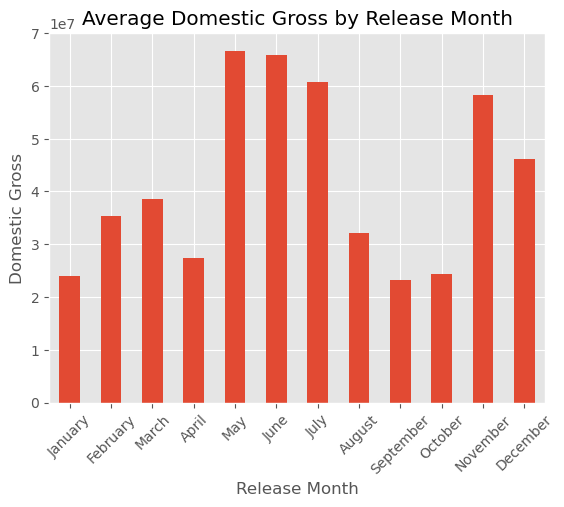

In [ ]:
tn_movie_budgets.groupby('release_month')['domestic_gross'].mean().sort_index(ascending=True).plot.bar()
plt.title('Average Domestic Gross by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Domestic Gross')
plt.xticks(rotation=45)
plt.style.use('ggplot');

/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_16648/3676455938.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tn_movie_budgets.groupby('release_month')['worldwide_gross'].mean().plot.bar()


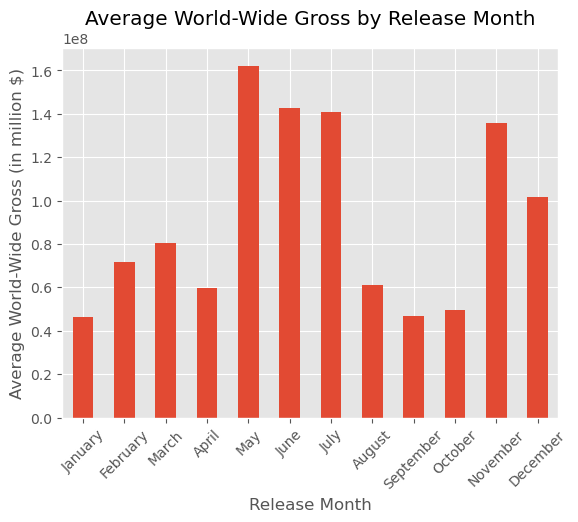

In [ ]:
tn_movie_budgets.groupby('release_month')['worldwide_gross'].mean().plot.bar()
plt.title('Average World-Wide Gross by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average World-Wide Gross (in million $)')
plt.xticks(rotation=45)
plt.style.use('ggplot');


/var/folders/gf/gqtw2hsd3xx5_9tt2z47xflr0000gn/T/ipykernel_16648/4143731676.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tn_movie_budgets_nonzero.groupby('release_month')['domestic_gross'].mean().plot.bar()


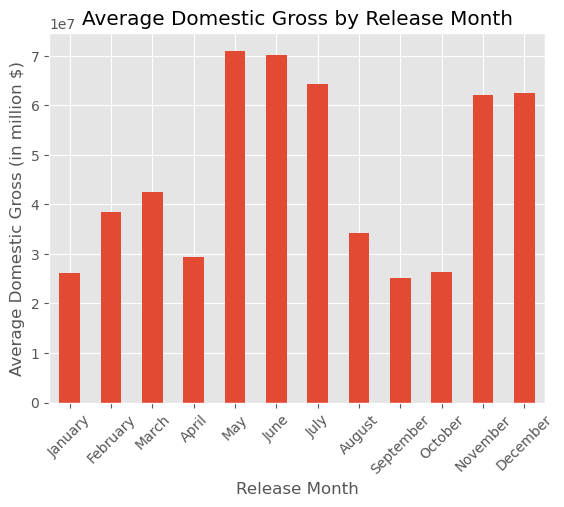

In [ ]:
# Re-running after getting rid of films for which we lack budget information
tn_movie_budgets_nonzero.groupby('release_month')['domestic_gross'].mean().plot.bar()
plt.title('Average Domestic Gross by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Domestic Gross (in million $)')
plt.xticks(rotation=45)
plt.style.use('ggplot');

# Domestic Gross vs. Production Budget

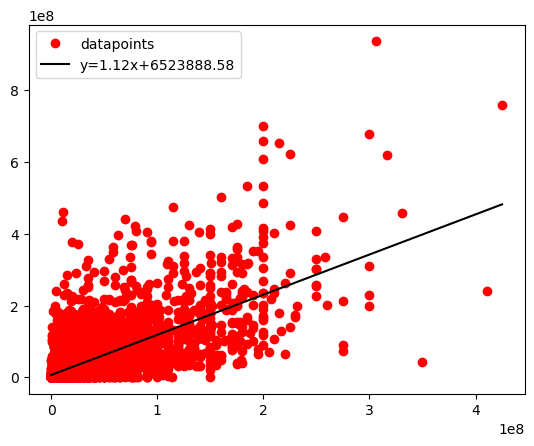

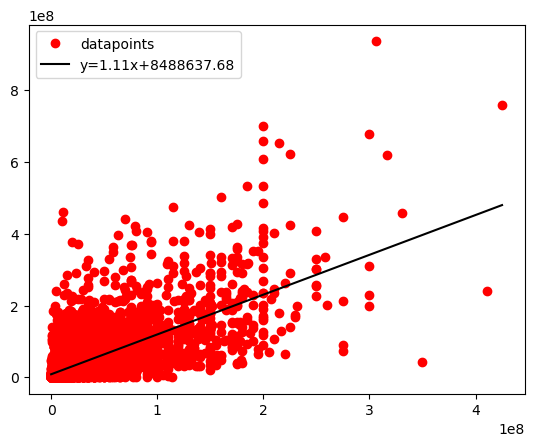

In [ ]:
# pulling in the lin_reg function
from lin_reg import best_line
# Running first with the whole dataset
best_line(tn_movie_budgets['production_budget'], tn_movie_budgets['domestic_gross'])
# And then after filtering out zero-budget films
best_line(tn_movie_budgets_nonzero['production_budget'], tn_movie_budgets_nonzero['domestic_gross'])


# Years

In [ ]:
# For how many years do we have data?
merged_movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23612 entries, 0 to 23611
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         23612 non-null  object 
 1   primary_title    23612 non-null  object 
 2   original_title   23607 non-null  object 
 3   start_year       23612 non-null  int64  
 4   runtime_minutes  21750 non-null  float64
 5   genres           23263 non-null  object 
 6   Unnamed: 0       23612 non-null  int64  
 7   id               23612 non-null  int64  
 8   popularity       23612 non-null  float64
 9   release_date     23612 non-null  object 
 10  vote_average     23612 non-null  float64
 11  vote_count       23612 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 2.2+ MB


In [ ]:
# The TN Data actually has everything we need for this analysis, although we'll 
# probably want to go in and do the same yearly filtering

tn_2000 = tn_movie_budgets[tn_movie_budgets['release_year'] >= 2000].copy()
tn_2000.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4387 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 4387 non-null   int64         
 1   release_date       4387 non-null   datetime64[ns]
 2   primary_title      4387 non-null   object        
 3   production_budget  4387 non-null   int64         
 4   domestic_gross     4387 non-null   int64         
 5   worldwide_gross    4387 non-null   int64         
 6   release_month      4387 non-null   category      
 7   release_year       4387 non-null   int32         
dtypes: category(1), datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 261.7+ KB


In [ ]:
# And we can do the same thing with our non-zero data
tn_2000_nonzero = tn_movie_budgets_nonzero[tn_movie_budgets_nonzero['release_year'] >= 2000].copy()
tn_2000_nonzero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3865 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3865 non-null   int64         
 1   release_date       3865 non-null   datetime64[ns]
 2   movie              3865 non-null   object        
 3   production_budget  3865 non-null   int64         
 4   domestic_gross     3865 non-null   int64         
 5   worldwide_gross    3865 non-null   int64         
 6   release_month      3865 non-null   category      
 7   release_year       3865 non-null   int32         
dtypes: category(1), datetime64[ns](1), int32(1), int64(4), object(1)
memory usage: 230.6+ KB


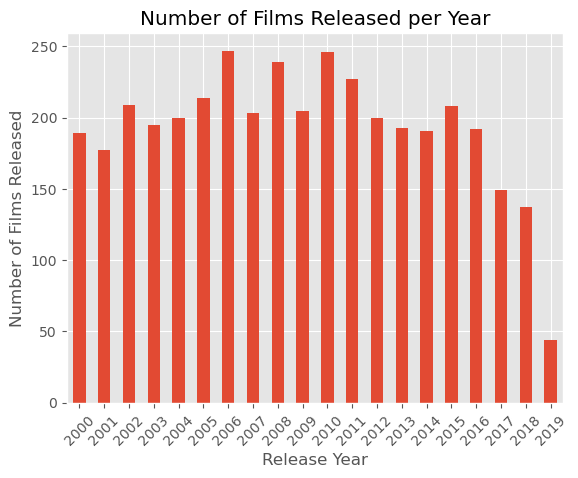

In [ ]:
# Graph the number of films we have per year
tn_2000_nonzero['release_year'].value_counts().sort_index().plot.bar()
plt.title('Number of Films Released per Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Films Released')
plt.xticks(rotation=45)
3plt.style.use('ggplot');

''

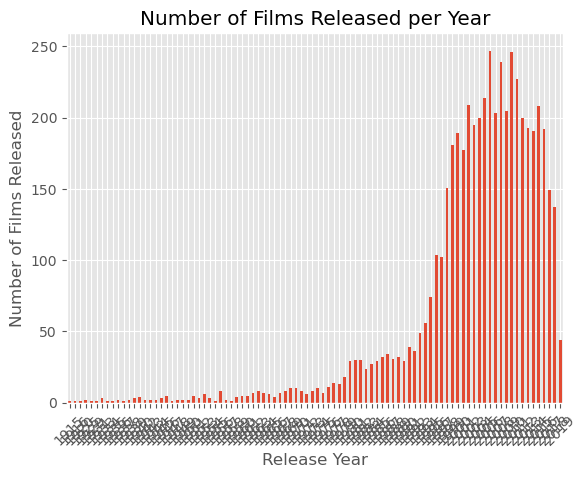

In [ ]:
# And probably worth comparing to the non-subsetted data:
tn_movie_budgets_nonzero['release_year'].value_counts().sort_index().plot.bar()
plt.title('Number of Films Released per Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Films Released')
plt.xticks(rotation=45)
plt.style.use('ggplot')
#plt.axvline(x=2000, color='blue', linewidth=20)
#plt.text(2000, plt.ylim()[1], '2000', ha='center', va='bottom', color='red')
;

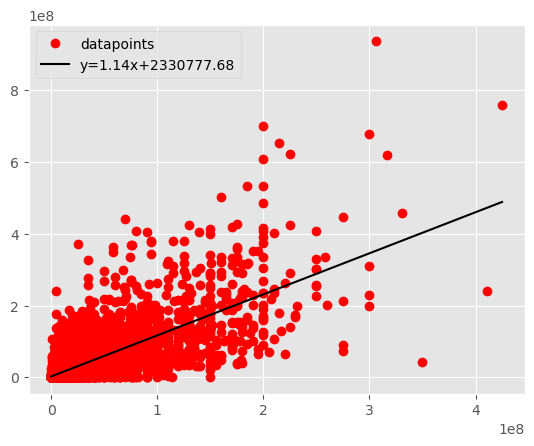

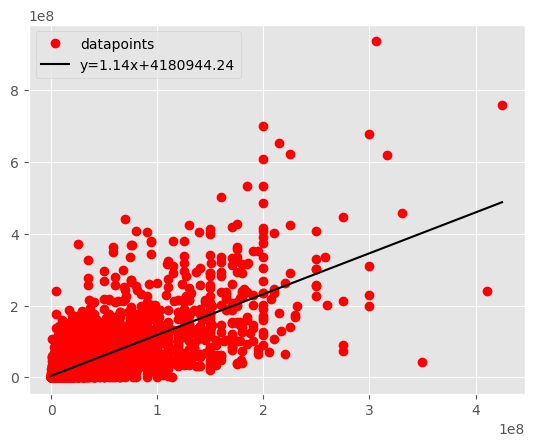

In [ ]:
# And then we can re-run our lin_reg function with the subsetted data

# Running first with the whole dataset
best_line(tn_2000['production_budget'], tn_2000['domestic_gross'])

# And then after filtering out zero-budget films
best_line(tn_2000_nonzero['production_budget'], tn_2000_nonzero['domestic_gross'])
